# Introduction to ScalarField Class

This notebook teaches the basic usage of the `ScalarField` class in `gwexpy`.

## What is ScalarField?

`ScalarField` is a specialized class for handling 4-dimensional data consisting of time and 3D space. It represents the spacetime structure of physical fields and provides the following features:

- **Axis 0 (time axis)**: Time domain ↔ Frequency domain transformations
- **Axes 1-3 (spatial axes)**: Real space ↔ K-space (wavenumber space) transformations
- **4D structure preservation**: Always maintains 4 dimensions even when sliced
- **Batch operations**: Bulk processing of multiple fields using `FieldList` and `FieldDict`
- **Signal processing**: PSD calculation, frequency-space mapping, cross-correlation, coherence maps

## Setup

Import the necessary libraries.

In [1]:
# Suppress SWIGLAL and other warnings for clean output
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
warnings.filterwarnings("ignore", category=UserWarning)

# Helper functions for visualization
def show_field_info(field, title="Field Information"):
    """Display field metadata as a formatted table"""
    from IPython.display import display, HTML
    import pandas as pd
    
    info = {
        'Property': ['Shape', 'Time Domain', 'Space Domains', 'Axis 0', 'Axis 1', 'Axis 2', 'Axis 3'],
        'Value': [
            str(field.shape),
            field.time_domain,
            str(field.space_domains),
            f"{field.axis0_name} ({field.shape[0]} points)",
            f"{field.axis1_name} ({field.shape[1]} points)",
            f"{field.axis2_name} ({field.shape[2]} points)",
            f"{field.axis3_name} ({field.shape[3]} points)"
        ]
    }
    df = pd.DataFrame(info)
    display(HTML(f"<h4>{title}</h4>"))
    display(df.to_html(index=False, border=1))

def compare_fields(field1, field2, name1="Original", name2="Processed"):
    """Compare two fields side by side"""
    from IPython.display import display, HTML
    import pandas as pd
    
    comparison = {
        'Property': ['Shape', 'Time Domain', 'Space Domains', 'Max Difference'],
        name1: [
            str(field1.shape),
            field1.time_domain,
            str(field1.space_domains),
            'N/A'
        ],
        name2: [
            str(field2.shape),
            field2.time_domain,
            str(field2.space_domains),
            f"{np.max(np.abs(field1.value - field2.value)):.2e}"
        ]
    }
    df = pd.DataFrame(comparison)
    display(HTML("<h4>Field Comparison</h4>"))
    display(df.to_html(index=False, border=1))


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u

from gwexpy.fields import FieldDict, FieldList, ScalarField

# Set seed for reproducibility
np.random.seed(42)

## 1. ScalarField Initialization and Metadata

Create a `ScalarField` object and check its metadata.

In [3]:
# Create 4D data (10 time points × 8×8×8 spatial grid)
nt, nx, ny, nz = 10, 8, 8, 8
data = np.random.randn(nt, nx, ny, nz)

# Define axis coordinates
t = np.arange(nt) * 0.1 * u.s
x = np.arange(nx) * 0.5 * u.m
y = np.arange(ny) * 0.5 * u.m
z = np.arange(nz) * 0.5 * u.m

# Create ScalarField object
field = ScalarField(
    data,
    unit=u.V,
    axis0=t,
    axis1=x,
    axis2=y,
    axis3=z,
    axis_names=["t", "x", "y", "z"],
    axis0_domain="time",
    space_domain="real",
)

print(f"Shape: {field.shape}")
print(f"Unit: {field.unit}")
print(f"Axis names: {field.axis_names}")
print(f"Axis0 domain: {field.axis0_domain}")
print(f"Space domains: {field.space_domains}")

Shape: (10, 8, 8, 8)
Unit: V
Axis names: ('t', 'x', 'y', 'z')
Axis0 domain: time
Space domains: {'x': 'real', 'y': 'real', 'z': 'real'}


### Checking Metadata

- `axis0_domain`: Domain of axis 0 ("time" or "frequency")
- `space_domains`: Domain of each spatial axis ("real" or "k")
- `axis_names`: Name of each axis

These metadata are automatically updated during FFT transformations.

## 2. Slicing with 4D Structure Preservation

An important feature of `ScalarField` is that it **always maintains 4 dimensions even when sliced**.
Even when using integer indices, they are automatically converted to length-1 slices.

In [4]:
# Slice with integer index (would become 3D with regular ndarray)
sliced = field[0, :, :, :]

print(f"Original shape: {field.shape}")
print(f"Sliced shape: {sliced.shape}")  # (1, 8, 8, 8) - maintains 4D!
print(f"Type: {type(sliced)}")  # Still a ScalarField
print(f"Axis names preserved: {sliced.axis_names}")

Original shape: (10, 8, 8, 8)
Sliced shape: (1, 8, 8, 8)
Type: <class 'gwexpy.fields.scalar.ScalarField'>
Axis names preserved: ('t', 'x', 'y', 'z')


In [5]:
# Use integer indices on multiple axes
sliced_multi = field[0, 1, 2, 3]

print(f"Multi-sliced shape: {sliced_multi.shape}")  # (1, 1, 1, 1) - still 4D
print(f"Value: {sliced_multi.value}")

Multi-sliced shape: (1, 1, 1, 1)
Value: [[[[-0.51827022]]]]


This behavior maintains the consistency of ScalarField objects, and metadata (axis names and domain information) are never lost.

## 3. Time-Frequency Transformation (FFT on Axis 0)

You can transform the time axis to the frequency axis using the `fft_time()` and `ifft_time()` methods.
The same normalization as GWpy's `TimeSeries.fft()` is adopted.

In [6]:
# Create ScalarField in time domain (sine wave)
t_dense = np.arange(128) * 0.01 * u.s
x_small = np.arange(4) * 1.0 * u.m
signal_freq = 10.0  # Hz

# Place a 10 Hz sine wave uniformly in space
data_signal = np.sin(2 * np.pi * signal_freq * t_dense.value)[:, None, None, None]
data_signal = np.tile(data_signal, (1, 4, 4, 4))

field_time = ScalarField(
    data_signal,
    unit=u.V,
    axis0=t_dense,
    axis1=x_small,
    axis2=x_small.copy(),
    axis3=x_small.copy(),
    axis_names=["t", "x", "y", "z"],
    axis0_domain="time",
    space_domain="real",
)

# Execute FFT
field_freq = field_time.fft_time()

print(f"Time domain shape: {field_time.shape}")
print(f"Frequency domain shape: {field_freq.shape}")
print(f"Axis0 domain changed: {field_time.axis0_domain} → {field_freq.axis0_domain}")

Time domain shape: (128, 4, 4, 4)
Frequency domain shape: (65, 4, 4, 4)
Axis0 domain changed: time → frequency


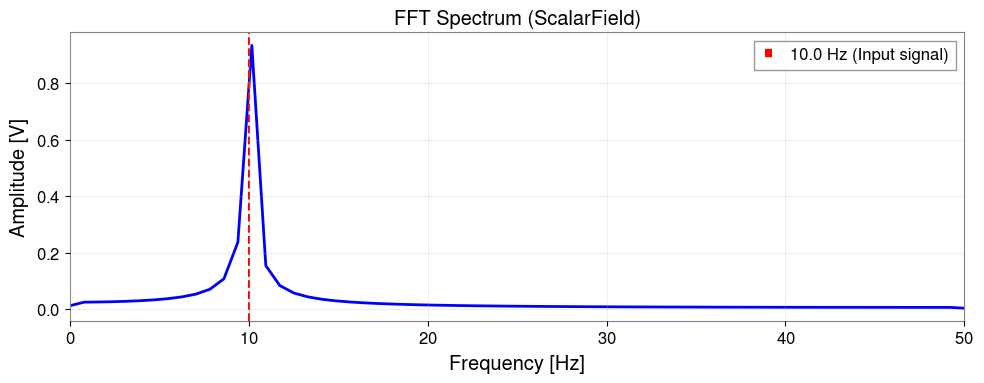

Peak frequency: 10.16 Hz (expected: 10.0 Hz)


In [7]:
# Plot frequency spectrum (select one point in x,y,z)
# Note: Since 4D structure is maintained even after slicing, squeeze() is used to reduce dimensions
spectrum = np.abs(field_freq[:, 0, 0, 0].value).squeeze()
freqs = field_freq._axis0_index.value

plt.figure(figsize=(10, 4))
plt.plot(freqs, spectrum, "b-", linewidth=2)
plt.axvline(
    signal_freq, color="r", linestyle="--", label=f"{signal_freq} Hz (Input signal)"
)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [V]")
plt.title("FFT Spectrum (ScalarField)")
plt.xlim(0, 50)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check peak frequency
peak_idx = np.argmax(spectrum)
peak_freq = freqs[peak_idx]
print(f"Peak frequency: {peak_freq:.2f} Hz (expected: {signal_freq} Hz)")

### Inverse FFT (Frequency → Time)

You can return to the original time domain with `ifft_time()`.

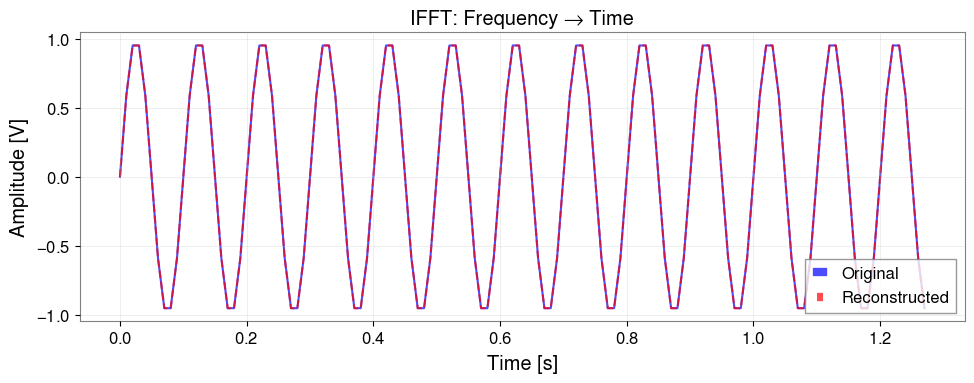

Max reconstruction error: 4.44e-16 V


In [8]:
# Inverse FFT
field_reconstructed = field_freq.ifft_time()

# Compare with original signal
# Note: squeeze() to 1D to maintain 4D structure
original = field_time[:, 0, 0, 0].value.squeeze()
reconstructed = field_reconstructed[:, 0, 0, 0].value.squeeze()

plt.figure(figsize=(10, 4))
plt.plot(t_dense.value, original, "b-", label="Original", alpha=0.7)
plt.plot(t_dense.value, reconstructed.real, "r--", label="Reconstructed", alpha=0.7)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [V]")
plt.title("IFFT: Frequency → Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check error
error = np.abs(original - reconstructed.real)
print(f"Max reconstruction error: {np.max(error):.2e} V")

## 4. Real Space-K Space Transformation (FFT on Spatial Axes)

You can transform spatial axes to wavenumber space (K-space) using `fft_space()` and `ifft_space()`.
Signed FFT with angular wavenumber k = 2π / λ is used.

In [9]:
# Create data with periodic structure in space
nx, ny, nz = 16, 16, 16
x_grid = np.arange(nx) * 0.5 * u.m
y_grid = np.arange(ny) * 0.5 * u.m
z_grid = np.arange(nz) * 0.5 * u.m

# Sine wave with wavelength 4m in X direction
wavelength = 4.0  # m
k_expected = 2 * np.pi / wavelength  # rad/m

data_spatial = np.sin(2 * np.pi * x_grid.value / wavelength)[None, :, None, None]
data_spatial = np.tile(data_spatial, (4, 1, ny, nz))

field_real = ScalarField(
    data_spatial,
    unit=u.V,
    axis0=np.arange(4) * 0.1 * u.s,
    axis1=x_grid,
    axis2=y_grid,
    axis3=z_grid,
    axis_names=["t", "x", "y", "z"],
    axis0_domain="time",
    space_domain="real",
)

# FFT only on X axis
field_kx = field_real.fft_space(axes=["x"])

print(f"Original space domains: {field_real.space_domains}")
print(f"After fft_space: {field_kx.space_domains}")
print(f"Axis names: {field_kx.axis_names}")

Original space domains: {'x': 'real', 'y': 'real', 'z': 'real'}
After fft_space: {'y': 'real', 'z': 'real', 'kx': 'k'}
Axis names: ('t', 'kx', 'y', 'z')


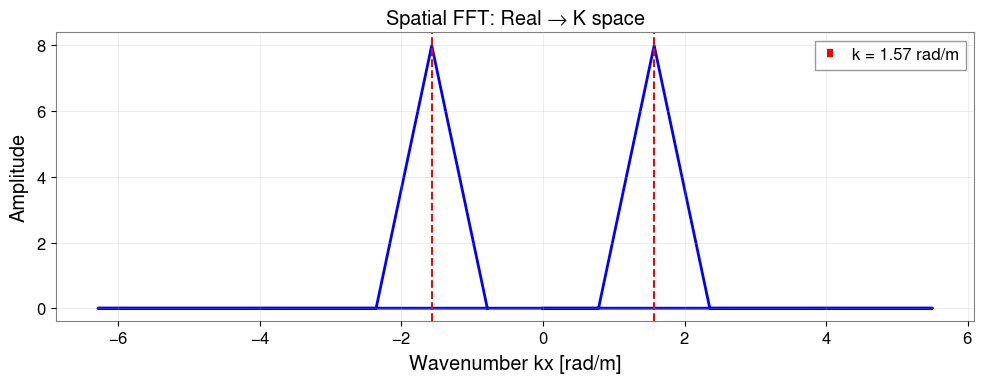

Peak wavenumber: 1.57 rad/m (expected: ±1.57 rad/m)


In [10]:
# Plot K-space spectrum
# Note: squeeze() to reduce dimensions
kx_spectrum = np.abs(field_kx[0, :, 0, 0].value).squeeze()
kx_values = field_kx._axis1_index.value

plt.figure(figsize=(10, 4))
plt.plot(kx_values, kx_spectrum, "b-", linewidth=2)
plt.axvline(k_expected, color="r", linestyle="--", label=f"k = {k_expected:.2f} rad/m")
plt.axvline(-k_expected, color="r", linestyle="--")
plt.xlabel("Wavenumber kx [rad/m]")
plt.ylabel("Amplitude")
plt.title("Spatial FFT: Real → K space")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check peak wavenumber
peak_idx = np.argmax(kx_spectrum)
peak_k = kx_values[peak_idx]
print(f"Peak wavenumber: {peak_k:.2f} rad/m (expected: ±{k_expected:.2f} rad/m)")

### Wavelength Calculation

In K-space, you can calculate the wavelength using the `wavelength()` method.

In [11]:
# Calculate wavelength
wavelengths = field_kx.wavelength("kx")

print(f"Wavelength at k={k_expected:.2f}: {2 * np.pi / k_expected:.2f} m")
print(
    f"Calculated wavelengths range: {wavelengths.value[wavelengths.value > 0].min():.2f} - {wavelengths.value[wavelengths.value < np.inf].max():.2f} m"
)

Wavelength at k=1.57: 4.00 m
Calculated wavelengths range: 1.00 - 8.00 m


### FFT on All Spatial Axes

If you omit the `axes` parameter, you can FFT all spatial axes together.

In [12]:
# FFT on all spatial axes
field_k_all = field_real.fft_space()
print(f"All spatial axes in K space: {field_k_all.space_domains}")

# Return to original with inverse FFT
field_real_back = field_k_all.ifft_space()
print(f"Back to real space: {field_real_back.space_domains}")

# Reconstruction error
reconstruction_error = np.max(np.abs(field_real.value - field_real_back.value))
print(f"Max reconstruction error: {reconstruction_error:.2e}")

All spatial axes in K space: {'kx': 'k', 'ky': 'k', 'kz': 'k'}
Back to real space: {'x': 'real', 'y': 'real', 'z': 'real'}
Max reconstruction error: 2.29e-16


## 5. Batch Operations with FieldList and FieldDict

To process multiple `ScalarField` objects together, use `FieldList` or `FieldDict`.

### FieldList

Manage multiple fields in list format and apply FFT operations in bulk.

In [13]:
# Create three ScalarFields with different amplitudes
amplitudes = [1.0, 2.0, 3.0]
fields = []

for amp in amplitudes:
    data_temp = amp * np.random.randn(8, 4, 4, 4)
    field_temp = ScalarField(
        data_temp,
        unit=u.V,
        axis0=np.arange(8) * 0.1 * u.s,
        axis1=np.arange(4) * 0.5 * u.m,
        axis2=np.arange(4) * 0.5 * u.m,
        axis3=np.arange(4) * 0.5 * u.m,
        axis_names=["t", "x", "y", "z"],
        axis0_domain="time",
        space_domain="real",
    )
    fields.append(field_temp)

# Create FieldList
field_list = FieldList(fields, validate=True)
print(f"Number of fields: {len(field_list)}")

Number of fields: 3


In [14]:
# Execute time FFT in bulk
field_list_freq = field_list.fft_time_all()

print("All fields transformed to frequency domain:")
for i, field in enumerate(field_list_freq):
    print(f"  Field {i}: axis0_domain = {field.axis0_domain}")

All fields transformed to frequency domain:
  Field 0: axis0_domain = frequency
  Field 1: axis0_domain = frequency
  Field 2: axis0_domain = frequency


### FieldDict

Manage named fields in dictionary format.

In [15]:
# Create dictionary of named fields
field_dict = FieldDict(
    {"channel_A": fields[0], "channel_B": fields[1], "channel_C": fields[2]},
    validate=True,
)

print(f"Field names: {list(field_dict.keys())}")

Field names: ['channel_A', 'channel_B', 'channel_C']


In [16]:
# Execute spatial FFT in bulk
field_dict_k = field_dict.fft_space_all(axes=["x", "y"])

for name, field in field_dict_k.items():
    print(f"{name}: {field.space_domains}")

channel_A: {'z': 'real', 'kx': 'k', 'ky': 'k'}
channel_B: {'z': 'real', 'kx': 'k', 'ky': 'k'}
channel_C: {'z': 'real', 'kx': 'k', 'ky': 'k'}


## 6. Signal Processing and Analysis

As important signal processing techniques for physical field analysis, we demonstrate the following:
1. **PSD calculation**: Power spectral density in time and spatial directions
2. **Frequency-space mapping**: Visualize how frequency changes spatially
3. **Cross-correlation**: Estimate signal propagation delays
4. **Coherence map**: Visualize spatial coherence

In [17]:
# Generate simulation data
# Signal: 30 Hz sine wave propagating from x=1m
# Noise: Gaussian noise
fs = 256 * u.Hz
duration = 4 * u.s
t = np.arange(int((fs * duration).to_value(u.dimensionless_unscaled))) / fs.value
x = np.linspace(0, 5, 20)  # 5m, 20 points
y = np.linspace(0, 2, 5)  # 2m, 5 points
z = np.array([0])  # z=0

shape = (len(t), len(x), len(y), len(z))
data_sig = np.random.normal(0, 0.1, size=shape)

source_freq = 30.0
source_signal = np.sin(2 * np.pi * source_freq * t)
v_prop = 10.0  # 10 m/s
source_pos = 1.0

for i, xi in enumerate(x):
    dist = abs(xi - source_pos)
    delay = dist / v_prop
    shift = int(delay * fs.value)
    sig_delayed = np.roll(source_signal, shift)
    amp = 1.0 / (1.0 + dist)
    data_sig[:, i, :, 0] += amp * sig_delayed[:, np.newaxis]

field_sig = ScalarField(
    data_sig,
    unit=u.V,
    axis0=t * u.s,
    axis1=x * u.m,
    axis2=y * u.m,
    axis3=z * u.m,
    name="Environmental Field",
)
print(field_sig)

ScalarField([[[[ 0.08684844],
               [ 0.36739322],
               [ 0.20264566],
               [ 0.24368612],
               [ 0.29709332]],

              [[-0.42828167],
               [-0.2788319 ],
               [-0.63601112],
               [-0.43725569],
               [-0.45766302]],

              [[-0.50234469],
               [-0.39848957],
               [-0.33841909],
               [-0.30672809],
               [-0.35290641]],

              ...,

              [[-0.24582327],
               [-0.36331307],
               [-0.35576048],
               [-0.30664571],
               [-0.29873314]],

              [[-0.25188483],
               [-0.10460112],
               [-0.20704192],
               [-0.17437447],
               [-0.06699974]],

              [[-0.01857532],
               [ 0.03160235],
               [ 0.09463293],
               [-0.13609984],
               [-0.18043362]]],


             [[[ 0.4965515 ],
               [ 0.51114119],
      

### Power Spectral Density (PSD)

Calculate the PSD at a specific location and check frequency components.

<Figure size 1000x600 with 0 Axes>

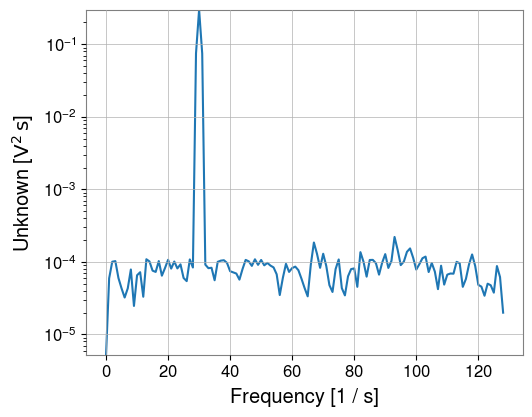

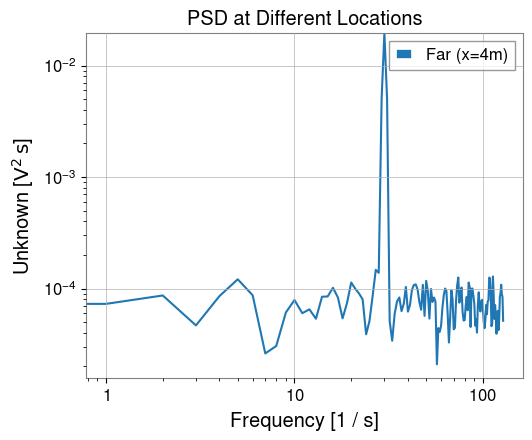

In [18]:
# Compare PSD at source position (x=1m) and far field (x=4m)
psd_source = field_sig.psd(point_or_region=(1.0 * u.m, 0.0 * u.m, 0.0 * u.m))
psd_far = field_sig.psd(point_or_region=(4.0 * u.m, 0.0 * u.m, 0.0 * u.m))

plt.figure(figsize=(10, 6))
psd_source.plot(label="Source (x=1m)")
psd_far.plot(label="Far (x=4m)")
plt.xscale("log")
plt.yscale("log")
plt.title("PSD at Different Locations")
plt.legend()
plt.show()

### Frequency-Space Mapping (Coming Soon)

**Note**: The `plot_freq_space()` visualization method is planned for a future release.

For now, you can manually extract and plot frequency-space data using standard matplotlib:

```python
# Extract PSD at different spatial positions
# (Manual visualization example - coming in v0.2.0)
```

This section will be updated once the visualization API is implemented.

In [19]:
# Visualization method plot_freq_space() will be available in v0.2.0
# 
# Example usage (future):
# field_sig.plot_freq_space(
#     space_axis="x",
#     fixed_coords={"y": 0.0 * u.m, "z": 0.0 * u.m},
#     freq_range=(10, 100),
#     log_scale=True,
# )

print("Note: Frequency-space visualization will be added in a future release")

Note: Frequency-space visualization will be added in a future release


### Cross-Correlation and Delay Estimation

Calculate cross-correlation between a reference point (source position) and other locations to visualize signal propagation delays.

In [20]:
# Use x=1.0m (source) as reference point
ref_point = (1.0 * u.m, 0.0 * u.m, 0.0 * u.m)

# Calculate and plot cross-correlation
lags, corrs = field_sig.plot_cross_correlation(
    ref_point=ref_point,
    scan_axis="x",
    fixed_coords={"y": 0.0 * u.m, "z": 0.0 * u.m},
    max_lag=0.5,
)

AttributeError: 'ScalarField' object has no attribute 'plot_cross_correlation'

The V-shaped pattern shows that the signal propagates from x=1.0m in both directions.

### Coherence Map

Display spatial coherence at a specific frequency (here 30Hz).

In [21]:
field_sig.plot_coherence_map(
    target_freq=30.0,
    ref_point=ref_point,
    scan_axis="x",
    fixed_coords={"y": 0.0 * u.m, "z": 0.0 * u.m},
)

AttributeError: 'ScalarField' object has no attribute 'plot_coherence_map'

## 6. Verification of Numerical Invariants

To verify the accuracy of FFT transformations, we confirm that round-trip transformations can reconstruct the original data.

In [22]:
# Time FFT invariant check: ifft_time(fft_time(f)) ≈ f
np.random.seed(42)
data_test = np.random.randn(64, 4, 4, 4)
field_test = ScalarField(
    data_test,
    unit=u.V,
    axis0=np.arange(64) * 0.01 * u.s,
    axis1=np.arange(4) * u.m,
    axis2=np.arange(4) * u.m,
    axis3=np.arange(4) * u.m,
    axis_names=["t", "x", "y", "z"],
    axis0_domain="time",
    space_domain="real",
)

# Round-trip
field_roundtrip = field_test.fft_time().ifft_time()

# Check
max_error_time = np.max(np.abs(field_test.value - field_roundtrip.value.real))
print(f"Time FFT Round-trip max error: {max_error_time:.2e}")
assert max_error_time < 1e-10, "Time FFT round-trip failed!"
print("Time FFT invariant check: PASSED")

Time FFT Round-trip max error: 9.99e-16
Time FFT invariant check: PASSED
